**How Indicative Are Age and Number of Hours Played on a UBC scientist-run Minecraft Server of a Player's Subscription Status to the game-related newsletter?**

In [22]:
library(tidymodels)
library(tidyverse)
library(cowplot)
library(repr)
set.seed(40)

## (1) Introduction:

This project aims to use data collected from a minecraft server run by UBC scientists to answer the following broad question: “What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?” More specifically, we would like to address the following question: “Can age and number of hours played predict whether a player is subscribed to the game-related newsletter?” This will help identify whether age and number of hours are predictive of subscribing to the game-related newsletter. To help answer these questions, we utilized data from the players.csv dataset. This file contains player age, number of hours played, and newsletter subscription status. This dataset also includes 196 observations. This data was collected through a minecraft server set up by a research group in computer science at UBC. A potential problem with it is that it has the subscription status of the player stored as a logical type of data. This will need to be changed to a factor type of data in order to perform KNN classification. In addition, people may lie about their name, gender, and age. Some players also report zero hours of gameplay, but it is unclear whether it is because they are new or simply uninterested in playing. This distinction is important in the context of making predictions. For example, if 18-year-olds normally game a lot, but have few played hours because they only recently joined the study, it could skew the predicted played hours for similar age individuals. In addition, if the "experience" variable is self-reported, then designations may be subjective and unreliable as predictors. Furthermore, age in this context is technically not a quantitative variable, since it is not continuous (technically it is discreet and qualitative), as it is only composed of integer numbers. However, for the purposes of this project, we will consider age as a quantitative variable so we can use KNN classification on the dataset. We have included a small section of the players.csv dataset below to help visualize what the dataset looks like.

In [4]:
players_url <- "https://raw.githubusercontent.com/Nyte1706/ds_project/20f5697cc19aad27c319f291e95b5d8504b792b5/players%20(1).csv"
players <- read_csv(players_url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## (2) Methods:

As mentioned above, the data that will help us address our question is the players.csv file. KNN classification will be used to predict a player’s subscription status based on age and hours played. Age and number of hours played will both be scaled so that they both contribute equally to the KNN model. The model will be tested with a test set of data. This model assumes that players input their real age, and a potential limitation is that it doesn’t account for gender or experience, which were also given in the players.csv dataset. To process the data, we will split the data into test (30%) and training sets (70%). The training set will be used to perform 5 fold cross-validation to determine the best value of k. Using this value of k, we will test the KNN classification model using the test set of data to determine how accurate the model is at predicting a player’s subscription status based on age and hours played.

## (3) Code and Results:

- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all figures should have a figure number and a legend


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `subscribe = fct_recode(as_factor(subscribe), Yes = "TRUE", No =
  "FALSE")`.
Caused by warning:
! Unknown levels in `f`: TRUE, FALSE”
→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 28 rows.
               ✖ Assigned data has 29 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 29 to size 28.

There were issues with some computations   A: x1
There 

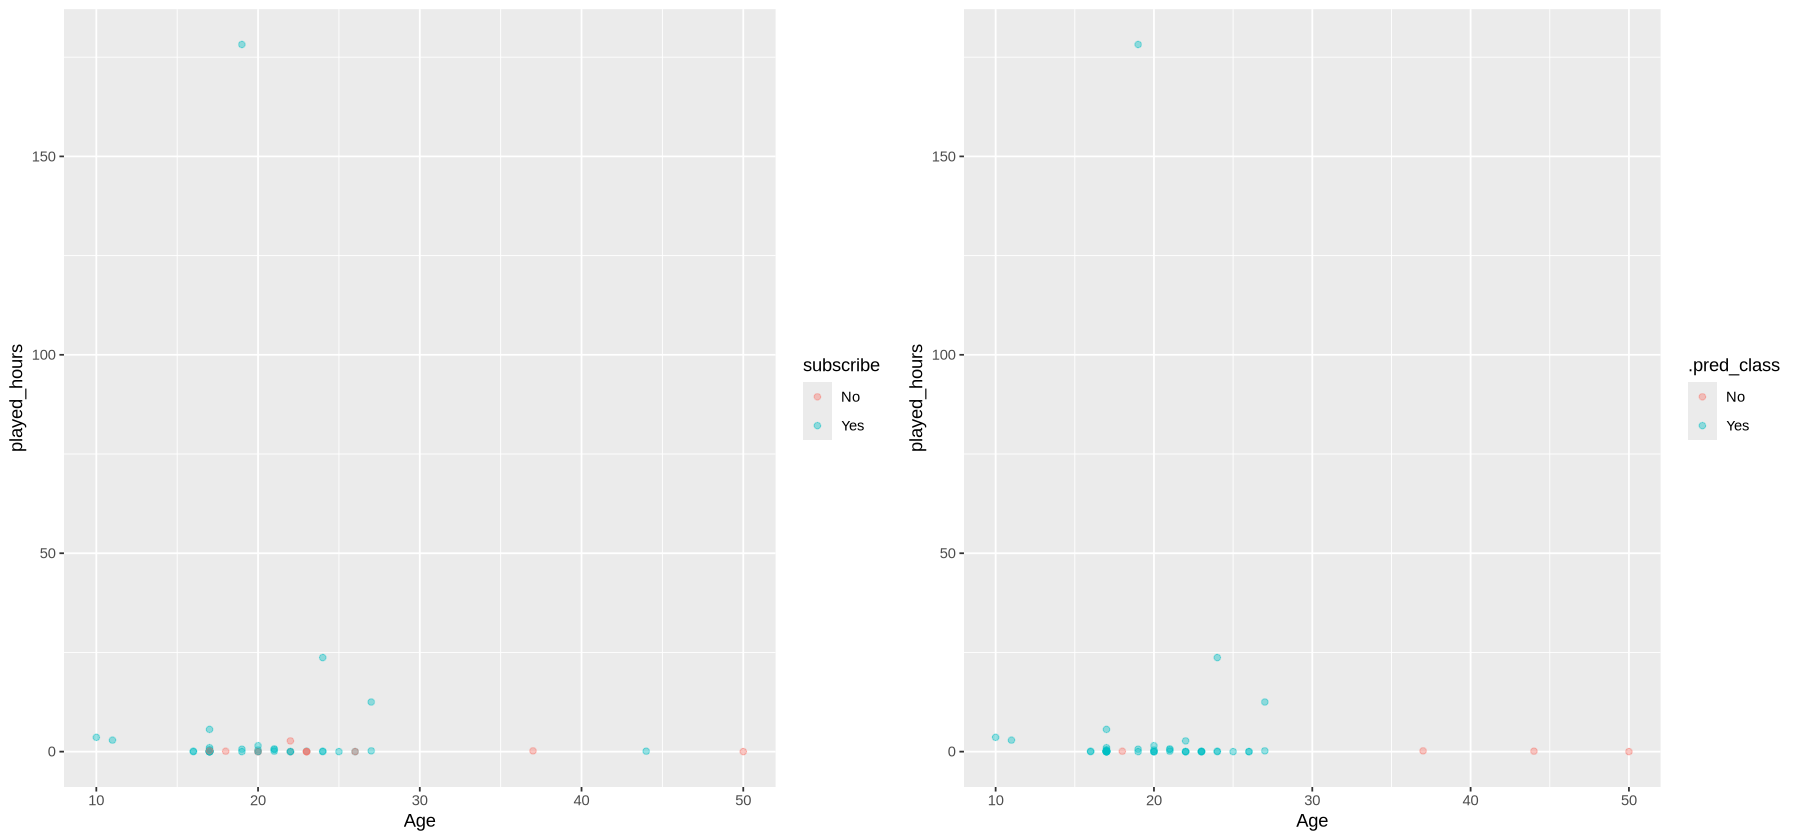

In [24]:
players <- players |>
    mutate(subscribe = fct_recode(as_factor(subscribe), Yes = "TRUE", No = "FALSE"))

k_vals <- tibble(neighbors = 1:25)

players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold_sets <- players_train |>
    vfold_cv(v = 5, strata = subscribe)

k_accuracies <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = vfold_sets, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    mutate(accuracy = mean) |>
    select(neighbors, accuracy)
    
k_accuracies_plot <- k_accuracies |>
    ggplot(aes(x = neighbors, y = accuracy)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K)", y = "Accuracy", title = "Fig. IDK: Accuracies associated with various K values.")

# -------------------------

best_k <- k_accuracies |>
    slice_max(accuracy) |>
    slice_min(neighbors) |> #what to do if tied for accuracy?
    pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = players_train)

players_predicted <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) 

players_predicted_accuracy <- players_predicted |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    slice_max(.estimate) |>
    pull(.estimate)

players_predicted_conf <- players_predicted |>
    conf_mat(truth = subscribe, estimate = .pred_class)



options(repr.plot.width = 15)

players_plot <- players_predicted |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.4)

players_predicted_plot <- players_predicted |>
    ggplot(aes(x = Age, y = played_hours, color = .pred_class)) +
    geom_point(alpha = 0.4)
#for billy: how do i improve the color stuff

plot_grid(players_plot, players_predicted_plot, ncol = 2)


#for billy: is it ok that i condensed this all?

In [20]:
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test) 
players_test_predictions|>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
players_test_predictions|>
  precision(truth = subscribe, estimate = .pred_class, event_level = "first")
players_test_predictions|>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7755102


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.1538462


## (4) Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?